If you don't have nettack repo cloned clone it (https://github.com/danielzuegner/nettack.git) and go to folder nettack file init.py and add a line there from .nettack import Nettack


In [53]:
import sys
from pathlib import Path

# Add the project root directory to sys.path
sys.path.append(str(Path("/Users/Ola/Desktop/ATDL_A3")))

from nettack.nettack import Nettack

In [54]:
import GNN_module.scripts as scripts #only used for on the fly reloads
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn.models import GAT, GCN
from sklearn.model_selection import ParameterGrid
import numpy as np

from GNN_module.scripts import *
from GNN_module.metrics import *
import torch.nn.functional as F


In [125]:
# Load the Planetoid dataset
dataset_cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset_cora[0]  # Access the single graph in the dataset
labels = data.y

# Prepare GAT model with parameters from your hyperparameter sweeps
s = load_best_sweep('sweeps/sweep_results_gat_cora.pkl')['hyperparameters']
gat = GAT(
    in_channels=data.num_features,
    hidden_channels=s['hidden_channels'] * s['heads'],
    num_layers=s['num_layers'],
    out_channels=dataset_cora.num_classes,  # Use the num_classes attribute directly
    heads=s['heads'],
    dropout=s['dropout'],
    act=F.elu
).to('cpu')

optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)

s2 = load_best_sweep('sweeps/sweep_results_gatv2_cora.pkl')['hyperparameters']

gatv2 = GAT(v2 = True,
             in_channels=dataset_cora.num_features, 
             hidden_channels=s2['hidden_channels']*s['heads'], 
             num_layers=s2['num_layers'], 
             out_channels=dataset_cora.num_classes, 
             heads=s['heads'], dropout=s2['dropout'], 
             act=F.elu)

optimizer_gatv2 = torch.optim.Adam(gatv2.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

Setting up the surrogate modesl

In [117]:
from torch_geometric.nn import GCNConv


from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch

# Define the surrogate model
class SurrogateGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SurrogateGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

# Hyperparameter options to test
learning_rates = [0.01, 0.005]
hidden_units = [16, 32]
best_val_loss = float('inf')
best_params = {}

# Iterate over different hyperparameter combinations
for lr in learning_rates:
    for hidden_channels in hidden_units:
        # Initialize the surrogate model with the current parameters
        surrogate_model = SurrogateGCN(in_channels=data.num_features, hidden_channels=hidden_channels, out_channels=dataset_cora.num_classes)
        optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=lr, weight_decay=5e-4)

        # Train the surrogate model and evaluate on the validation set
        surrogate_model.train()
        for epoch in range(200):  # Train for fewer epochs per search iteration to save time
            optimizer.zero_grad()
            out = surrogate_model(data.x, data.edge_index)
            loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

        # Evaluate on the validation set
        surrogate_model.eval()
        with torch.no_grad():
            val_out = surrogate_model(data.x, data.edge_index)
            val_loss = F.cross_entropy(val_out[data.val_mask], data.y[data.val_mask])

        # Track the best parameters based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {'learning_rate': lr, 'hidden_channels': hidden_channels}

# Print best hyperparameters
print("Best hyperparameters for the surrogate model:", best_params)

# Train the final surrogate model with the best parameters
surrogate_model = SurrogateGCN(
    in_channels=data.num_features,
    hidden_channels=best_params['hidden_channels'],
    out_channels=dataset_cora.num_classes
)
optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=best_params['learning_rate'], weight_decay=5e-4)


surrogate_model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = surrogate_model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# Step 4: Extract weights from the surrogate model
state_dict = surrogate_model.state_dict()
W1 = state_dict['conv1.lin.weight'].detach().cpu().numpy().T  # First layer weight
W2 = state_dict['conv2.lin.weight'].detach().cpu().numpy().T  # Second layer weight
u = np.eye(dataset_cora.num_classes)  # Placeholder for the softmax layer


Best hyperparameters for the surrogate model: {'learning_rate': 0.01, 'hidden_channels': 32}


Convert the PyTorch Geometric data to formats required by Nettack


In [118]:
from nettack.nettack import utils
import scipy.sparse as sp


# Convert the PyTorch Geometric data to formats required by Nettack
adj_matrix = data.edge_index
features = data.x.numpy()
labels = data.y.numpy()

# Create adjacency matrix in sparse format - only stroing non-zero elements and their positions
_A_obs = sp.coo_matrix((np.ones(len(adj_matrix[0])), (adj_matrix[0], adj_matrix[1])),
                       shape=(data.num_nodes, data.num_nodes))

# Preprocess the adjacency matrix - making the matrix symmetric (edges are seen as undirected)
_A_obs = _A_obs + _A_obs.T
#removing redundant edges - making the adjecency matric unweighted
_A_obs[_A_obs > 1] = 1

# Identify the largest connected component
lcc = utils.largest_connected_components(_A_obs)
#only nodes in the LCC stay in the adjecency matric
# this improves attack's stability by focusing on the largest portion of the graph that is fully connected
_A_obs = _A_obs[lcc][:, lcc]
#only keep features of the nodes that belong to LCC and the same for labels
_X_obs = features[lcc].astype('float32')
_z_obs = labels[lcc]
#converting feature matrix to a list of lists format  - for efficieny 
_X_obs = sp.lil_matrix(_X_obs)


Selecting 1 largest connected components


In [119]:
# Choose a target node from the test set for attack
target_nodes = data.test_mask.nonzero(as_tuple=True)[0]  # All test nodes
u = target_nodes[0].item()  # Pick the first test node for demonstration

# Initialize Nettack with the surrogate model weights
nettack = Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u, verbose=True)

# Define attack parameters
direct_attack = True
n_influencers = 1 if direct_attack else 5
n_perturbations = int(_A_obs.sum(0).A1[u])  # Number of perturbations, set to the node's degree
perturb_features = True
perturb_structure = True

# Perform the attack
nettack.reset()
nettack.attack_surrogate(
    n_perturbations, perturb_structure=perturb_structure,
    perturb_features=perturb_features, direct=direct_attack, n_influencers=n_influencers
)


##### Starting attack #####
##### Attack node with ID 1708 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 7 perturbations #####
##### ...1/7 perturbations ... #####
Feature perturbation: [1708 1132]
##### ...2/7 perturbations ... #####
Feature perturbation: [1708 1170]
##### ...3/7 perturbations ... #####
Feature perturbation: [1708 1005]
##### ...4/7 perturbations ... #####
Feature perturbation: [1708  763]
##### ...5/7 perturbations ... #####
Feature perturbation: [1708 1075]
##### ...6/7 perturbations ... #####
Edge perturbation: [1708   85]
##### ...7/7 perturbations ... #####
Feature perturbation: [1708 1336]


In [126]:
import torch
import torch.nn.functional as F
import numpy as np

# Define hyperparameters
retrain_iters = 5
classification_margins_clean = []
class_distrs_clean = []

# Train and evaluate GAT model multiple times on clean data
for _ in range(retrain_iters):
    # Reset and train GAT model on clean data
    gat = GAT(
        in_channels=data.num_features,
        hidden_channels=s['hidden_channels'] * s['heads'],
        num_layers=s['num_layers'],
        out_channels=dataset_cora.num_classes,
        heads=s['heads'],
        dropout=s['dropout'],
        act=F.elu
    ).to('cpu')

    optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Training loop (simplified)
    gat.train()
    for epoch in range(100):  # Number of epochs
        optimizer_gat.zero_grad()
        out = gat(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer_gat.step()

    # Evaluate the model on the target node
    gat.eval()
    with torch.no_grad():
        logits = gat(data.x, data.edge_index)
        probs_before_attack = F.softmax(logits[u], dim=0).numpy()
        
        # Store the class distribution and margin for clean data
        class_distrs_clean.append(probs_before_attack)
        best_second_class_before = (probs_before_attack - 1000 * np.eye(dataset_cora.num_classes)[data.y[u]]).argmax()
        margin_before = probs_before_attack[data.y[u]] - probs_before_attack[best_second_class_before]
        classification_margins_clean.append(margin_before)


In [127]:
import torch
from torch_geometric.utils import from_scipy_sparse_matrix

# Access perturbed adjacency and feature matrices
perturbed_adj = nettack.adj_preprocessed  # This is typically in sparse matrix format, perturbed adjecency matrix
perturbed_features = nettack.X_obs  # This is also in sparse format (LIL or CSR), perturbed feature matrix

# Convert the perturbed adjacency matrix to a compatible edge_index format
edge_index, edge_weight = from_scipy_sparse_matrix(perturbed_adj)
# Convert them to PyTorch tensors if needed
perturbed_features = torch.tensor(perturbed_features.toarray(), dtype=torch.float)




In [173]:
#`lcc` is a list of indices for nodes in the largest connected component
# ensures that the masks align with the nodes in the largest connected component, resulting in masks that correspond directly to the nodes in _A_obs, _X_obs, and _z_obs (the perturbed adjacency matrix, features, and labels).
# Adjust features, labels, and masks to match the LCC
subset_features = data.x[lcc]
subset_y = data.y[lcc]
train_mask = data.train_mask[lcc]
val_mask = data.val_mask[lcc]
test_mask = data.test_mask[lcc]

# Check shapes for alignment
print("Adjusted features shape:", subset_features.shape)
print("Adjusted labels shape:", subset_y.shape)
print("Adjusted train_mask length:", len(train_mask))

# Map the original node indices to indices in the LCC
lcc_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(lcc)}
adjusted_edge_index = torch.tensor([
    [lcc_mapping[idx.item()] for idx in edge] 
    for edge in data.edge_index.T if edge[0].item() in lcc_mapping and edge[1].item() in lcc_mapping
]).T

# Check the adjusted edge_index
print("Adjusted edge_index shape:", adjusted_edge_index.shape)
print("Max node index in adjusted_edge_index:", adjusted_edge_index.max().item())


Adjusted features shape: torch.Size([2485, 1433])
Adjusted labels shape: torch.Size([2485])
Adjusted train_mask length: 2485
Adjusted edge_index shape: torch.Size([2, 10138])
Max node index in adjusted_edge_index: 2484


In [129]:
subset_y = data.y[lcc]


print(len(train_mask), len(val_mask), len(test_mask), len(subset_y))
print(perturbed_features.shape[0])  # Should match the lengths above

2485 2485 2485 2485
2485


In [130]:
classification_margins_corrupted = []
class_distrs_retrain = []

# Train and evaluate GAT model multiple times on perturbed data
for _ in range(retrain_iters):
    # Reset and train GAT model on perturbed data
    gat = GAT(
        in_channels=data.num_features,
        hidden_channels=s['hidden_channels'] * s['heads'],
        num_layers=s['num_layers'],
        out_channels=dataset_cora.num_classes,
        heads=s['heads'],
        dropout=s['dropout'],
        act=F.elu
    ).to('cpu')

    optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)

    # Training loop
    gat.train()
    for epoch in range(100):  # Number of epochs
        optimizer_gat.zero_grad()
        out = gat(perturbed_features, edge_index)
        loss = criterion(out[train_mask], subset_y[train_mask])
        loss.backward()
        optimizer_gat.step()

    # Evaluate the model on the perturbed node
    gat.eval()
    with torch.no_grad():
        logits = gat(perturbed_features, edge_index)
        probs_after_attack = F.softmax(logits[u], dim=0).numpy()

        # Store the class distribution and margin for perturbed data
        class_distrs_retrain.append(probs_after_attack)
        best_second_class_after = (probs_after_attack - 1000 * np.eye(dataset_cora.num_classes)[subset_y[u]]).argmax()
        margin_after = probs_after_attack[subset_y[u]] - probs_after_attack[best_second_class_after]
        classification_margins_corrupted.append(margin_after)


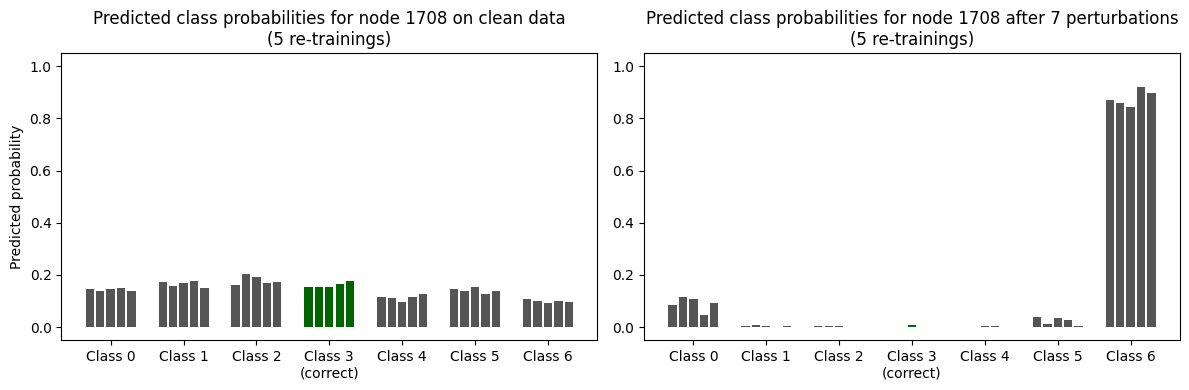

In [131]:
import matplotlib.pyplot as plt

def make_xlabel(ix, correct):
    if ix == correct:
        return f"Class {ix}\n(correct)"
    return f"Class {ix}"

# Plot the clean and perturbed class distributions
figure = plt.figure(figsize=(12, 4))

# Clean data visualization
plt.subplot(1, 2, 1)
center_ixs_clean = []
for ix, block in enumerate(np.array(class_distrs_clean).T):
    x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
    center_ixs_clean.append(np.mean(x_ixs))
    color = 'darkgreen' if ix == data.y[u] else '#555555'
    plt.bar(x_ixs, block, color=color)
plt.ylim((-.05, 1.05))
plt.ylabel("Predicted probability")
plt.xticks(center_ixs_clean, [make_xlabel(k, data.y[u]) for k in range(dataset_cora.num_classes)])
plt.title(f"Predicted class probabilities for node {u} on clean data\n({retrain_iters} re-trainings)")

# Perturbed data visualization
plt.subplot(1, 2, 2)
center_ixs_retrain = []
for ix, block in enumerate(np.array(class_distrs_retrain).T):
    x_ixs = np.arange(len(block)) + ix * (len(block) + 2)
    center_ixs_retrain.append(np.mean(x_ixs))
    color = 'darkgreen' if ix == data.y[u] else '#555555'
    plt.bar(x_ixs, block, color=color)
plt.ylim((-.05, 1.05))
plt.xticks(center_ixs_retrain, [make_xlabel(k, data.y[u]) for k in range(dataset_cora.num_classes)])
plt.title(f"Predicted class probabilities for node {u} after {n_perturbations} perturbations\n({retrain_iters} re-trainings)")
plt.tight_layout()
plt.show()


Definig the function that does all the above steps for a provided model - GAT or GATv2

In [169]:
def train_and_evaluate(model_class, data, edge_index, features, labels, train_mask,  hyperparameters, retrain_iters=5, epochs=100, lr=0.005, v2=False):
    # Debug prints to ensure shapes are correct
    print("features shape:", features.shape)  # Should be (2485, num_features)
    print("labels shape:", labels.shape)      # Should be (2485,)
    print("train_mask length:", len(train_mask))   # Should be 2485
    
    classification_margins = []
    class_distributions = []

    act = hyperparameters.get('act', F.elu)


    for _ in range(retrain_iters):
        # Initialize the model with the sweep-based hyperparameters and version flag
        model = model_class(
            v2=v2,
            in_channels=features.size(1),
            hidden_channels=hyperparameters['hidden_channels'] * hyperparameters['heads'],
            num_layers=hyperparameters['num_layers'],
            out_channels=labels.max().item() + 1,
            heads=hyperparameters['heads'],
            dropout=hyperparameters['dropout'],
            act=act
        ).to('cpu')

        optimizer = Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(features, edge_index)
            loss = criterion(out[train_mask], labels[train_mask])
            loss.backward()
            optimizer.step()

        # Evaluation
        model.eval()
        with torch.no_grad():
            logits = model(features, edge_index)
            probs = F.softmax(logits[u], dim=0).numpy()

            # Calculate margins
            best_second_class = (probs - 1000 * np.eye(labels.max().item() + 1)[labels[u]]).argmax()
            margin = probs[labels[u]] - probs[best_second_class]

            # Store results
            class_distributions.append(probs)
            classification_margins.append(margin)

    return classification_margins, class_distributions


In [138]:
# Load hyperparameters from sweeps for both GAT and GATv2
hyperparameters_gat = load_best_sweep('sweeps/sweep_results_gat_cora.pkl')['hyperparameters']
hyperparameters_gatv2 = load_best_sweep('sweeps/sweep_results_gatv2_cora.pkl')['hyperparameters']


In [146]:
# Baseline: GAT on clean data
classification_margins_gat_clean, class_distributions_gat_clean = train_and_evaluate(
    GAT, data, data.edge_index, data.x, data.y, data.train_mask,  
    hyperparameters=hyperparameters_gat, v2=False
)

# Baseline: GATv2 on clean data
classification_margins_gatv2_clean, class_distributions_gatv2_clean = train_and_evaluate(
    GAT, data, data.edge_index, data.x, data.y, data.train_mask, 
    hyperparameters=hyperparameters_gatv2, v2=True
)


In [147]:
# GAT on perturbed data
classification_margins_gat_perturbed, class_distributions_gat_perturbed = train_and_evaluate(
    GAT, data, edge_index, perturbed_features, subset_y, train_mask, 
    hyperparameters=hyperparameters_gat, v2=False
)

# GATv2 on perturbed data
classification_margins_gatv2_perturbed, class_distributions_gatv2_perturbed = train_and_evaluate(
    GAT, data, edge_index, perturbed_features, subset_y, train_mask,
    hyperparameters=hyperparameters_gatv2, v2=True
)


In [150]:
u

1708

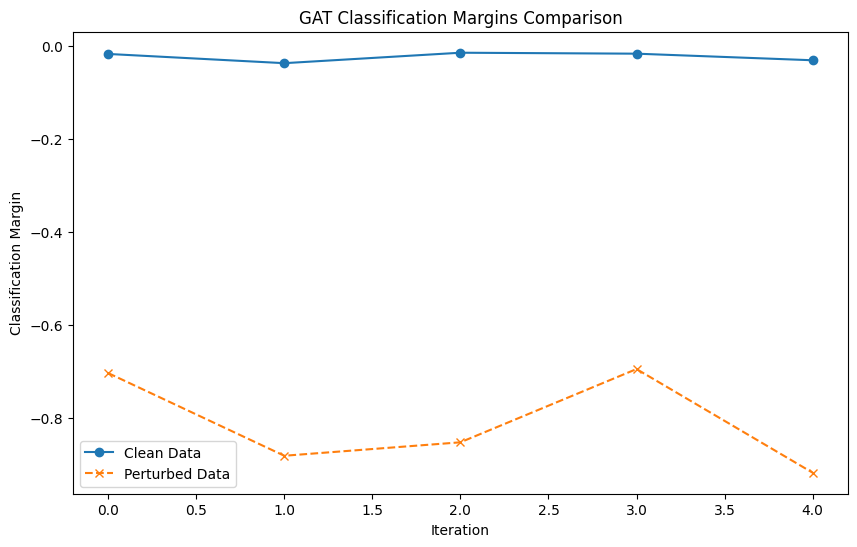

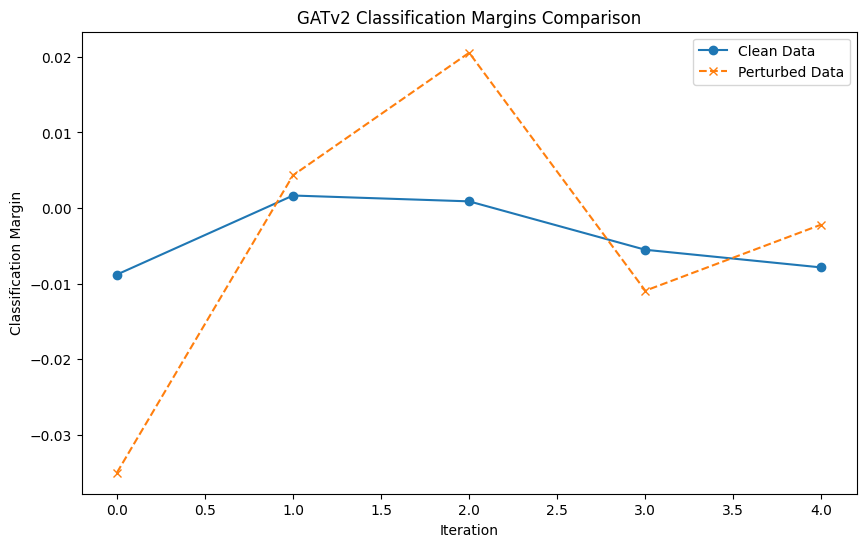

Target node label: 3
Debug: True label for target node is 3


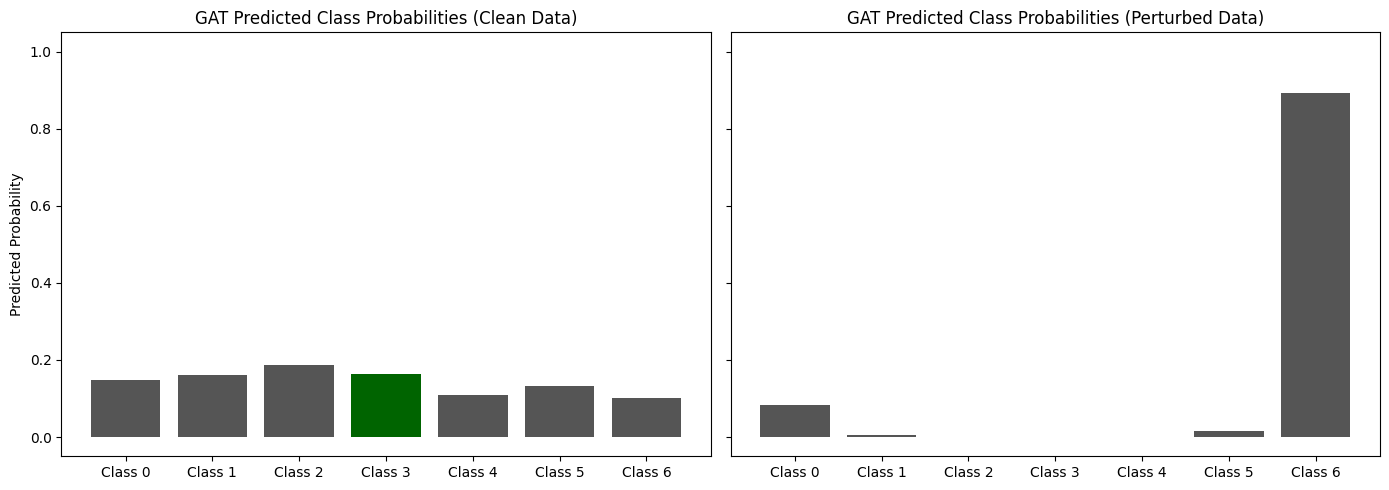

Debug: True label for target node is 3


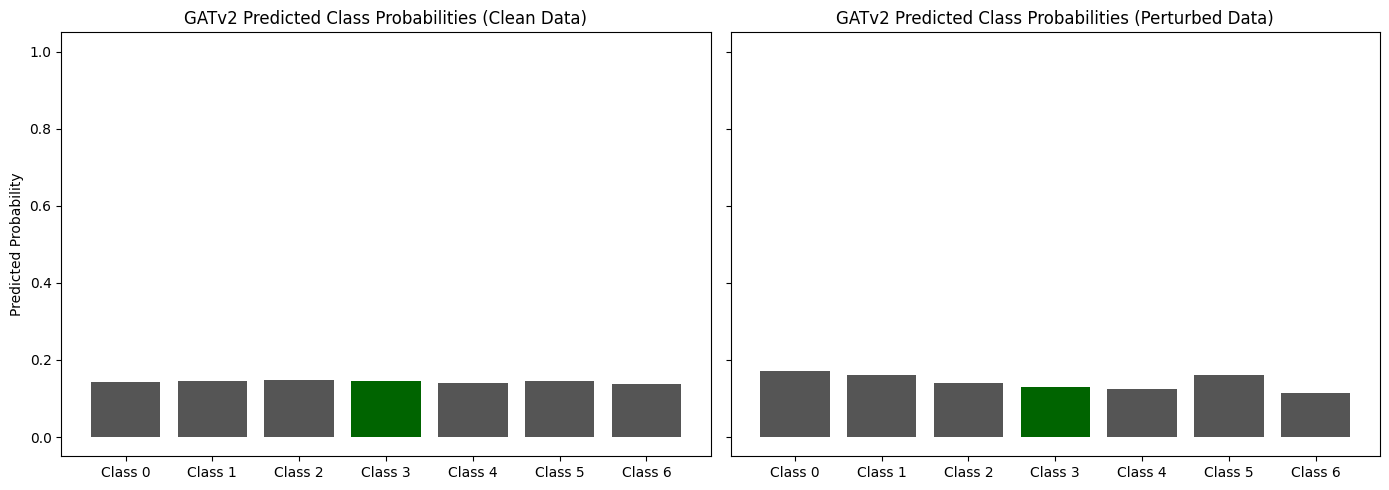

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function for margin plot
def plot_margins(margins_clean, margins_perturbed, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(margins_clean, label="Clean Data", marker='o')
    plt.plot(margins_perturbed, label="Perturbed Data", linestyle="--", marker='x')
    plt.xlabel("Iteration")
    plt.ylabel("Classification Margin")
    plt.title(f"{model_name} Classification Margins Comparison")
    plt.legend()
    plt.show()

# Plot classification margins for GAT
plot_margins(classification_margins_gat_clean, classification_margins_gat_perturbed, "GAT")

# Plot classification margins for GATv2
plot_margins(classification_margins_gatv2_clean, classification_margins_gatv2_perturbed, "GATv2")

# Define a helper function for class probability distributions
def plot_class_distributions(class_distr_clean, class_distr_perturbed, true_label, model_name):
    num_classes = len(class_distr_clean[0])
    class_labels = np.arange(num_classes)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # Ensure true_label is an integer
    true_label = int(true_label)
    print(f"Debug: True label for target node is {true_label}")  # Debugging line

    # Plot clean distribution
    clean_probs = np.mean(class_distr_clean, axis=0)
    axes[0].bar(class_labels, clean_probs, color=['darkgreen' if i == true_label else '#555555' for i in class_labels])
    axes[0].set_ylim((-.05, 1.05))
    axes[0].set_ylabel("Predicted Probability")
    axes[0].set_xticks(class_labels)
    axes[0].set_xticklabels([f"Class {i}" for i in class_labels])
    axes[0].set_title(f"{model_name} Predicted Class Probabilities (Clean Data)")

    # Plot perturbed distribution
    perturbed_probs = np.mean(class_distr_perturbed, axis=0)
    axes[1].bar(class_labels, perturbed_probs, color=['darkgreen' if i == true_label else '#555555' for i in class_labels])
    axes[1].set_ylim((-.05, 1.05))
    axes[1].set_xticks(class_labels)
    axes[1].set_xticklabels([f"Class {i}" for i in class_labels])
    axes[1].set_title(f"{model_name} Predicted Class Probabilities (Perturbed Data)")
    
    plt.tight_layout()
    plt.show()

# Set the target node and verify the label
print("Target node label:", data.y[u].item())  # Verify the correct label

# Plot class distributions for GAT
plot_class_distributions(class_distributions_gat_clean, class_distributions_gat_perturbed, data.y[u].item(), "GAT")

# Plot class distributions for GATv2
plot_class_distributions(class_distributions_gatv2_clean, class_distributions_gatv2_perturbed, data.y[u].item(), "GATv2")


In [171]:
# Adjust the masks to match the largest connected component (LCC)
train_mask = data.train_mask[lcc]
val_mask = data.val_mask[lcc]
test_mask = data.test_mask[lcc]
subset_y = data.y[lcc]
subset_features = data.x[lcc]


# Ensure the masks and labels have the same length as `perturbed_features`
print("Adjusted train_mask length:", len(train_mask))
print("Adjusted val_mask length:", len(val_mask))
print("Adjusted test_mask length:", len(test_mask))
print("Adjusted labels length (subset_y):", len(subset_y))
print("Perturbed features shape:", perturbed_features.shape[0])  # Should match the lengths above


Adjusted train_mask length: 2485
Adjusted val_mask length: 2485
Adjusted test_mask length: 2485
Adjusted labels length (subset_y): 2485
Perturbed features shape: 2485


In [176]:
# Initialize lists to store results across nodes
classification_margins_gat_clean_all = []
classification_margins_gat_perturbed_all = []
classification_margins_gatv2_clean_all = []
classification_margins_gatv2_perturbed_all = []

# Filter test mask to include only LCC indices
test_nodes_in_lcc = torch.where(test_mask)[0]

# Sample target nodes from this filtered set
num_samples = 10
if len(test_nodes_in_lcc) < num_samples:
    print("Warning: Not enough test nodes to sample the requested number.")
target_nodes = test_nodes_in_lcc[torch.randint(0, len(test_nodes_in_lcc), (num_samples,))]
for u in target_nodes:
    print(f"\nProcessing target node: {u.item()}")

    # Initialize Nettack for the specific target node with the surrogate model weights
    nettack = Nettack(_A_obs, _X_obs, _z_obs, W1, W2, u.item(), verbose=True)

    # Define attack parameters
    direct_attack = True
    n_influencers = 1 if direct_attack else 5
    n_perturbations = int(_A_obs.sum(0).A1[u]) # Number of perturbations, here set to the node's degree
    perturb_features = True
    perturb_structure = True

    print(f"Performing attack with {n_perturbations} perturbations on node {u.item()}.")

    # Perform the attack to generate perturbed data for the specific node
    nettack.reset()
    nettack.attack_surrogate(
        n_influencers=n_influencers,
        perturb_structure=perturb_structure,
        perturb_features=perturb_features, 
        direct=direct_attack,
        n_perturbations=n_perturbations
    )

    # Access perturbed adjacency and feature matrices
    perturbed_adj = nettack.adj_preprocessed  # Sparse matrix format
    perturbed_features = nettack.X_obs  # Sparse matrix format

    # Convert the perturbed adjacency matrix to a compatible edge_index format
    edge_index, edge_weight = from_scipy_sparse_matrix(perturbed_adj)
    # Convert perturbed features to a dense tensor if needed
    perturbed_features = torch.tensor(perturbed_features.toarray(), dtype=torch.float)

    # GAT on clean data
    print("Evaluating GAT on clean data...")
    classification_margins_gat_clean, _ = train_and_evaluate(
        GAT, data, adjusted_edge_index, subset_features, subset_y, train_mask, 
        hyperparameters=hyperparameters_gat, v2=False
    )
    
    # GAT on perturbed data
    print("Evaluating GAT on perturbed data...")
    classification_margins_gat_perturbed, _ = train_and_evaluate(
        GAT, data, edge_index, perturbed_features, subset_y, train_mask,
        hyperparameters=hyperparameters_gat, v2=False
    )

    # GATv2 on clean data
    print("Evaluating GATv2 on clean data...")
    classification_margins_gatv2_clean, _ = train_and_evaluate(
        GAT, data, adjusted_edge_index,subset_features, subset_y, train_mask, 
        hyperparameters=hyperparameters_gatv2, v2=True
    )
    
    # GATv2 on perturbed data
    print("Evaluating GATv2 on perturbed data...")
    classification_margins_gatv2_perturbed, _ = train_and_evaluate(
        GAT, data, edge_index, perturbed_features, subset_y, train_mask,
        hyperparameters=hyperparameters_gatv2, v2=True
    )

    # Aggregate margins for each node
    classification_margins_gat_clean_all.append(classification_margins_gat_clean)
    classification_margins_gat_perturbed_all.append(classification_margins_gat_perturbed)
    classification_margins_gatv2_clean_all.append(classification_margins_gatv2_clean)
    classification_margins_gatv2_perturbed_all.append(classification_margins_gatv2_perturbed)

# Calculate average margins for each model and condition
avg_gat_clean = np.mean(classification_margins_gat_clean_all)
avg_gat_perturbed = np.mean(classification_margins_gat_perturbed_all)
avg_gatv2_clean = np.mean(classification_margins_gatv2_clean_all)
avg_gatv2_perturbed = np.mean(classification_margins_gatv2_perturbed_all)

print("\nSummary of Results:")
print("Average Classification Margins for GAT (Clean):", avg_gat_clean)
print("Average Classification Margins for GAT (Perturbed):", avg_gat_perturbed)
print("Average Classification Margins for GATv2 (Clean):", avg_gatv2_clean)
print("Average Classification Margins for GATv2 (Perturbed):", avg_gatv2_perturbed)



Processing target node: 2173
Performing attack with 3 perturbations on node 2173.
##### Starting attack #####
##### Attack node with ID 2173 using structure and feature perturbations #####
##### Attacking the node directly #####
##### Performing 3 perturbations #####
##### ...1/3 perturbations ... #####
Feature perturbation: [2173 1132]
##### ...2/3 perturbations ... #####
Feature perturbation: [2173 1381]
##### ...3/3 perturbations ... #####
Feature perturbation: [2173 1075]
Evaluating GAT on clean data...
features shape: torch.Size([2485, 1433])
labels shape: torch.Size([2485])
train_mask length: 2485
Evaluating GAT on perturbed data...
features shape: torch.Size([2485, 1433])
labels shape: torch.Size([2485])
train_mask length: 2485
Evaluating GATv2 on clean data...
features shape: torch.Size([2485, 1433])
labels shape: torch.Size([2485])
train_mask length: 2485
Evaluating GATv2 on perturbed data...
features shape: torch.Size([2485, 1433])
labels shape: torch.Size([2485])
train_mask

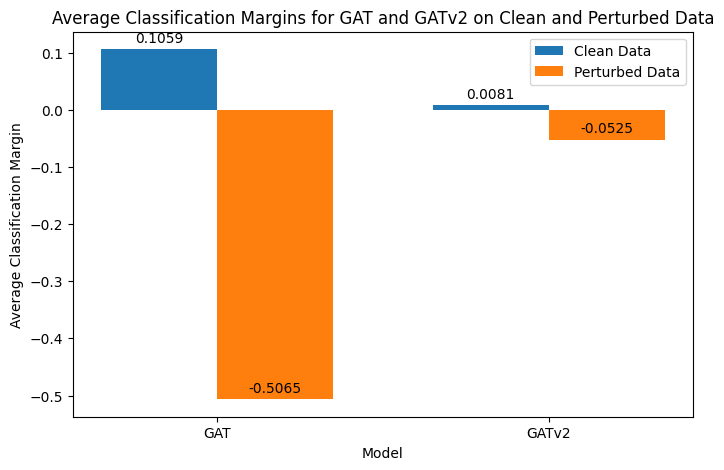

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['GAT', 'GATv2']
clean_margins = [avg_gat_clean, avg_gatv2_clean]
perturbed_margins = [avg_gat_perturbed, avg_gatv2_perturbed]

# Create a bar plot
x = np.arange(len(models))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, clean_margins, width, label='Clean Data')
bars2 = ax.bar(x + width/2, perturbed_margins, width, label='Perturbed Data')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Average Classification Margin')
ax.set_title('Average Classification Margins for GAT and GATv2 on Clean and Perturbed Data')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the values on top of each bar for clarity
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


/var/folders/tf/1b9ww3w15_g2r2jv_lv16k8h0000gp/T/ipykernel_95246/3791115792.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True)


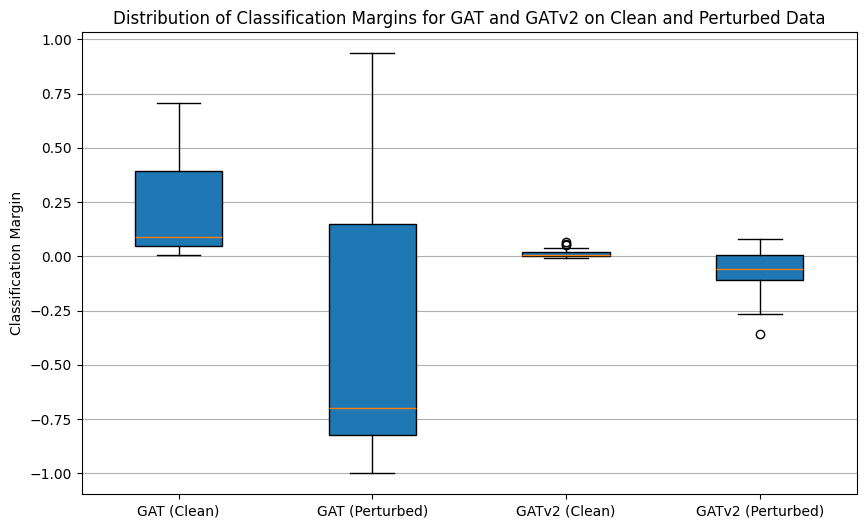

In [110]:
# Flatten each list of classification margins across nodes
data = [
    np.concatenate(classification_margins_gat_clean_all).ravel(),
    np.concatenate(classification_margins_gat_perturbed_all).ravel(),
    np.concatenate(classification_margins_gatv2_clean_all).ravel(),
    np.concatenate(classification_margins_gatv2_perturbed_all).ravel()
]

labels = [
    'GAT (Clean)', 
    'GAT (Perturbed)', 
    'GATv2 (Clean)', 
    'GATv2 (Perturbed)'
]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True)
plt.ylabel('Classification Margin')
plt.title('Distribution of Classification Margins for GAT and GATv2 on Clean and Perturbed Data')
plt.grid(axis='y')

plt.show()
